In [1]:
"""
Topic:        Project 2
Subject:      Carbon Emissions
Date:         xx/xx/xxxx
Name:         Leo Knauth
Worked with:  --


""";

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import adfuller

from fbprophet import Prophet 

import warnings
warnings.filterwarnings('ignore')

import itertools

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV

from pandas.plotting import autocorrelation_plot

import re

import sys
import os

from functools import reduce

# from helpers import make_plots, make_plots_2, find_best_params, get_fuller_test


## Helper functions

In [2]:
def calc_RMSE(validation_data, prediction_data):
   """
   Calculate RMSE
   """
   a = np.array(validation_data)
   b = np.array(prediction_data)

   return np.sqrt(np.mean((b-a)**2))

In [3]:
def get_fuller_test(series):
    values = series.values
    result = adfuller(values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

In [4]:
def make_plots(data, lags=None):
    '''
    plotting the data with specified number of lags.
    plotting raw data, then ACF and PACF
    '''
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    data.plot(ax=raw, figsize=(12, 6))
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

In [5]:
def make_plots_2(data, lags=None):
    '''
    plotting rolling mean, rolling std and original as per number of lags
    '''
    rolling_mean = data.rolling(window = lags).mean()
    rolling_std = data.rolling(window = lags).std()
    
    original = plt.plot(data, color='black',label = 'Original Timeseries')
    mean = plt.plot(rolling_mean, color='red', label = 'Rolling Mean')
    std = plt.plot(rolling_std, color='orange', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Original, Rolling Mean, Standard Deviation')
    sns.despine()
    plt.show()

In [6]:
def find_best_params(array):
    '''
    findind the best parametes using grid lock search
    '''
    
    # creating the  parameters as tuples
    p = d = q = range(0, 3)
    pdq = list(itertools.product(p, d, q))
    results = {}
    for param in pdq:
        
        try:
            model = ARIMA(array ,order = param )
            fit = model.fit()
            results[str(param)] = fit.aic
            
        except:
            continue

    print(min(results, key=results.get))
    return results

## Importing the pickles

In [7]:
# df_gdp = pd.read_pickle("gdp_per_capita.pkl")

In [8]:
# df_gdp.head()

In [24]:
df_co2_clean = pd.read_pickle('co2_clean.pkl')
df_co2_clean.set_index('country', inplace = True)

In [10]:
# df_co2 = pd.read_pickle('co2_per_capita.pkl')

In [27]:
df_co2_clean

,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,...,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
country,,,,,,,,,,,,,,,,,,,,,
Algeria,0.505686,0.475155,0.484803,0.553244,0.689270,0.671353,0.699885,0.845271,1.096571,1.317743,...,2.899236,2.762220,3.257010,3.113135,3.312875,3.328945,3.564361,3.480977,3.562504,3.785654
Argentina,2.521022,2.314937,2.536699,2.639906,2.790763,2.856316,2.968070,3.274030,3.449364,3.648299,...,3.502902,4.072844,4.160611,4.464492,4.582394,4.785170,4.483564,4.466338,4.676320,4.774982
Australia,8.871958,9.264776,9.797169,10.647757,10.356861,10.868811,11.055640,11.418580,11.596569,11.761816,...,17.461840,17.346237,17.773976,17.893128,17.859906,18.016313,18.037269,16.752301,16.772660,16.182094
Austria,4.758555,5.157335,5.392745,5.253796,5.368049,5.433418,5.726656,6.013441,6.789261,6.955571,...,8.889629,8.778800,9.017238,8.649446,8.319712,8.183160,7.438353,7.969244,7.606392,7.095971
Bangladesh,0.047542,0.053152,0.053090,0.054050,0.053261,0.054676,0.060728,0.057307,0.056908,0.053188,...,0.248178,0.286703,0.267095,0.338118,0.336645,0.319161,0.355868,0.377610,0.401268,0.426003
Belgium,10.581606,11.336839,11.044611,11.174203,11.096730,11.288688,12.406281,12.889146,13.050410,12.578504,...,11.144728,10.743691,10.419898,10.198066,9.792963,9.797337,9.772561,10.169529,9.513115,9.194220
Brazil,0.694761,0.698277,0.691653,0.668255,0.741322,0.743104,0.847031,0.899493,0.975798,1.042472,...,1.770560,1.837108,1.867213,1.849542,1.913506,2.023773,1.899718,2.152981,2.209100,2.256672
Bulgaria,3.837600,4.260697,5.264859,5.645189,5.899563,6.626313,7.101516,7.867143,7.212770,7.527687,...,6.033541,6.006152,6.189984,6.364376,6.911699,6.690139,5.674513,5.961127,6.722385,6.153028
Canada,11.119486,11.130316,12.314229,12.812833,12.914330,13.748569,14.500101,14.401854,15.723026,15.990964,...,17.499531,17.289814,17.439926,16.862318,17.004124,16.350399,15.260099,14.672016,14.807039,14.573717


In [28]:
df_gdp_clean = pd.read_pickle('gdp_clean.pkl')
df_gdp_clean.set_index('country', inplace = True)

In [29]:
df_gdp_clean.head()

,1962,1963,1964,1965,1966,1967,1968,1969,1970,1971,...,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012
country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,1188.0,1185.0,1182.0,1182.0,1168.0,1173.0,1187.0,1178.0,1174.0,1092.0,...,1097.0,1067.0,1146.0,1173.0,1298.0,1311.0,1548.0,1637.0,1695.0,1893.0
Albania,2832.0,2926.0,3023.0,3129.0,3242.0,3359.0,3475.0,3587.0,3712.0,3849.0,...,6274.0,6672.0,7075.0,7476.0,7977.0,8644.0,8994.0,9374.0,9640.0,9811.0
Algeria,4481.0,5551.0,5693.0,5916.0,5478.0,5811.0,6319.0,6747.0,7227.0,6427.0,...,11251.0,11575.0,12077.0,12088.0,12289.0,12314.0,12285.0,12494.0,12606.0,12779.0
Andorra,17805.0,19248.0,20809.0,22496.0,24320.0,26291.0,28422.0,30726.0,33216.0,33032.0,...,34500.0,36330.0,39787.0,42738.0,43442.0,41426.0,41735.0,38982.0,41958.0,41926.0
Angola,4034.0,4176.0,4573.0,4840.0,5043.0,5253.0,5093.0,5158.0,5397.0,5614.0,...,3819.0,4087.0,4667.0,5445.0,6453.0,7103.0,7039.0,7047.0,7094.0,7230.0


In [14]:
df_urban_com = pd.read_pickle('urban_com.pkl')

In [13]:
# select_years = list(map( lambda x : str(x), range(1962, 2013)))
# select_years;

In [25]:
# df_gdp_years = df_gdp[['country'] + select_years]

In [ ]:
# df_gdp_years.head()

In [ ]:
# df_gdp_clean = df_gdp_years.dropna().reset_index()

In [ ]:
# df_gdp_clean.drop('index', 1, inplace = True)

In [ ]:
# df_gdp_clean.to_pickle('gdp_clean.pkl')

In [26]:
# df_co2_years = df_co2[['country'] + select_years]

In [27]:
# df_co2_years.head(200)

In [ ]:
# df_co2_clean = df_co2_years.dropna().reset_index()

In [ ]:
# df_co2_clean.drop('index', 1, inplace = True)

In [ ]:
# df_co2_clean.loc['mean'] = df_co2_clean.mean()

In [ ]:
# df_co2_clean.to_pickle('co2_clean.pkl')

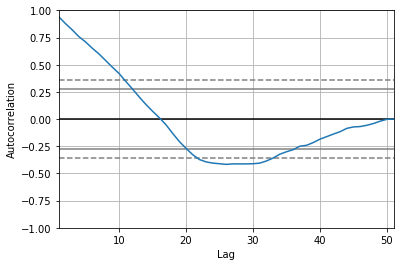

In [28]:
# autocorrelation for a sample country

autocorrelation_plot(df_co2_clean.iloc[17][1:])

In [29]:
array = np.array(df_co2_clean.iloc[17][1:])
series = df_co2_clean.iloc[17][1:]

In [30]:
model = ARIMA(array, order=(5,1,0))

In [31]:
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   50
Model:                 ARIMA(5, 1, 0)   Log Likelihood                 -25.676
Method:                       css-mle   S.D. of innovations              0.404
Date:                Tue, 16 Apr 2019   AIC                             65.352
Time:                        16:32:59   BIC                             78.736
Sample:                             1   HQIC                            70.449
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0610      0.059     -1.038      0.305      -0.176       0.054
ar.L1.D.y     -0.0434      0.145     -0.299      0.766      -0.327       0.241
ar.L2.D.y     -0.0336      0.145     -0.232      0.8

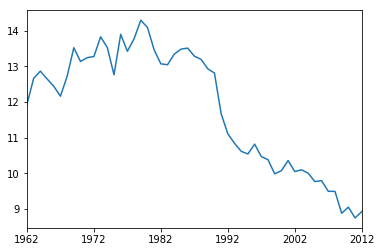

In [32]:
series.plot()

In [ ]:
# difference for detrending
diff = list()
for i in range(1, len(values)):
    value = values[i] - values[i - 1]
    diff.append(value)
plt.plot(diff)

In [ ]:
# detrending with linear regression

'''
note to self: detrending is necessary, but apparently ARIMA does it for you.

'''

X = [i for i in range(0, len(series))]
X = np.reshape(X, (len(X), 1))
y = series.values

# print(y)

model = LinearRegression()
model.fit(X, y)
# calculate trend

trend = model.predict(X)
# plot trend
plt.plot(y)
plt.plot(trend)
plt.show()
# detrend
detrended = [y[i]-trend[i] for i in range(0, len(series))]
# plot detrended
plt.plot(detrended)
plt.show()

In [ ]:
'''
In order to use Arima I must first transpose my dataframe and set a dateIndex.

Do not know how to rename the index. 
''';

In [15]:
df_co2_transpose = df_co2_clean.transpose()
df_co2_transpose.columns = df_co2_transpose.iloc[0]
df_co2_transpose.drop('country',0, inplace = True)
# df_co2_transpose = df_co2_transpose.rename(index = str, columns={"country": "year"}) 
df_co2_transpose = df_co2_transpose.apply(pd.to_numeric)


# df_co2_transpose.index.names = ['year']
# df_co2_transpose = df_co2_transpose.reindex(df_co2_transpose.index.rename(['year']))
df_co2_transpose;
# df_co2_transpose.info()

In [18]:
# df_co2_transpose
    

In [ ]:
'''
filter df_gdp_clean by countries that we also have CO2 data for
'''
df_gdp_com = df_gdp_clean[df_gdp_clean['country'].isin(df_co2_clean['country'])].reset_index().drop('index', 1)

In [ ]:
# df_co2_clean[df_co2_clean['country'].isin(df_gdp_clean['country'])]

In [ ]:
# df_gdp_com
df_gdp_transpose = df_gdp_com.transpose()
df_gdp_transpose.columns = df_gdp_transpose.iloc[0]
df_gdp_transpose.drop('country',0, inplace = True)
# df_gdp_com = df_gdp_transpose.rename(index = str, columns={"country": "year"}) 
df_gdp_transpose = df_gdp_transpose.apply(pd.to_numeric)


# df_gdp_transpose.index.names = ['year']
# df_gdp_transpose = df_gdp_transpose.reindex(df_gdp_com.index.rename(['year']))
df_gdp_transpose.tail()
# df_gdp_com.info()

In [ ]:
'''
find the betas of gdp/c and co2/c per year for all countries
''';

In [ ]:
# betas = {}
df_ratios = df_gdp_transpose.copy()

for year in select_years:
    
    for country in df_gdp_transpose.columns:
#         print(year)
#         print(country)
        year1 = str(year).strip()
        df_ratios.loc[year1][country] = df_co2_transpose.loc[year1][country] / df_gdp_transpose.loc[year1][country]
        
        


In [ ]:
df_ratios;

In [ ]:
'''
creating test data train data split
'''
df_ratios_train = df_ratios.loc['1962':'2002']
df_co2_train = df_co2_transpose.loc['1962':'2002']
df_gdp_train = df_gdp_transpose.loc['1962':'2002']

In [ ]:
df_ratios_train.tail()

## Plotting the co2 emissions per capita / gdp per capita ratios for all coutries

In [5]:
for country in df_ratios_train.columns:

    series = df_ratios_train[country]
    series.plot(title = country)
    plt.show()

NameError: name 'df_ratios_train' is not defined

Looks like more developed countries generally have a similar trend in the ratios. 

In [ ]:
series = df_ratios_train['Germany']
# series = df_ratios['Germany']
series.plot()

In [ ]:
series = df_ratios_train['Algeria']
series.plot()

In [ ]:
'''
running ARIMA on all the countries
''';

In [ ]:
for country in df_ratios_train.columns:
    array = np.array(df_ratios_train[country])
    model = ARIMA(array, order=(0,1,1))
    model_fit = model.fit(disp=0)
    print('\n\n', country)
    print(model_fit.summary())

In [ ]:

array = np.array(df_ratios_train['Germany'])
model = ARIMA(array, order=(0,1,1))
fit = model.fit(disp=0)

print(fit.summary())

In [ ]:
make_plots(df_ratios_train['Germany'], lags = 15)

In [ ]:
make_plots_2(df_ratios_train['Germany'], lags = 3)

In [ ]:
df_ratios_train['Germany'].diff().std()

In [ ]:
make_plots_2(df_ratios_train['Germany'].diff(), lags = 3)

In [ ]:
'''
now making it stationary with a diff function
'''

make_plots(df_ratios_train['Germany'].diff(), lags = 15)

In [ ]:
get_fuller_test(df_ratios_train['Germany'])

## Grid lock search for best parameters

In [ ]:
array = np.array(df_ratios_train['Germany'])
find_best_params(array)

In [ ]:
# array = np.array(df_ratios_train['Germany'].diff())
# find_best_params(array)

In [ ]:
df_co2_train = df_co2_transpose.loc['1962':'2007']

In [ ]:
array = np.array(df_co2_train['Germany'])
find_best_params(array)

## Test for stationality
In order to use an ARIMA model the time series has to be stationary. We can test that by using the fuller test

In [ ]:
make_plots(df_co2_train['Germany'], lags = 12)

In [ ]:
make_plots(df_co2_train['Germany'].diff(), lags = 12)

In [ ]:
get_fuller_test(df_co2_train['Germany'])

In [ ]:
get_fuller_test(df_co2_train['Germany'].diff().dropna())

In [ ]:
'''
creating train beta df
'''

reg_years = list(map( lambda x : str(x), range(1962, 2003)))
reg_years;
df_betas = df_co2_train.copy()
df_betas['beta'] = np.nan
df_betas.head()
for year in reg_years:
    lr1 = LinearRegression()
    x = np.array(df_gdp_train.loc[year])
    y = np.array(df_co2_train.loc[year])
    lr1.fit(x.reshape(-1, 1), y.reshape(-1, 1))
    df_betas.loc[year]['beta'] = (lr1.coef_[0][0])
df_betas = df_betas[['beta']]

In [ ]:
''' 
creating validation beta df

'''




reg_years = list(map( lambda x : str(x), range(2003, 2008)))
reg_years;
df_betas_val = df_co2_transpose.copy()
df_betas_val['beta'] = np.nan
df_betas_val.head()
for year in reg_years:
    lr1 = LinearRegression()
    x = np.array(df_gdp_transpose.loc[year])
    y = np.array(df_co2_transpose.loc[year])
    lr1.fit(x.reshape(-1, 1), y.reshape(-1, 1))
    df_betas_val.loc[year]['beta'] = (lr1.coef_[0][0])
df_betas_val = df_betas_val[['beta']]
df_betas_val = df_betas_val.loc['2003':'2007']

In [ ]:
''' 
creating test beta df

'''




reg_years = list(map( lambda x : str(x), range(2007, 2013)))
reg_years;
df_betas_test = df_co2_transpose.copy()
df_betas_test['beta'] = np.nan
df_betas_test.head()
for year in reg_years:
    lr1 = LinearRegression()
    x = np.array(df_gdp_transpose.loc[year])
    y = np.array(df_co2_transpose.loc[year])
    lr1.fit(x.reshape(-1, 1), y.reshape(-1, 1))
    df_betas_test.loc[year]['beta'] = (lr1.coef_[0][0])
df_betas_test = df_betas_test[['beta']]
df_betas_test = df_betas_test.loc['2008':'2012']

In [ ]:
sns.lineplot(y = df_betas['beta'], x = df_betas.index.values.astype(int))

In [ ]:
# fuller_test(df_betas_test['beta'])

In [ ]:
'''
finding the best params for training data betas
'''

array = np.array(df_betas['beta'])
find_best_params(array)

In [ ]:
df_betas_val

In [ ]:
df_betas_test

## Actual forecast code

In [ ]:
# predictions = []
# df_beta_hist = df_betas.copy().dropna()

# val_years = list(map( lambda x : (x), range(2003, 2008)))
# for year in val_years:
#     model = ARIMA(df_beta_hist, order = (1, 0, 2))
#     fit = model.fit()
# #     pred = fit.predict(start = 1998, end= year)
# #     pred = fit.predict(start = pd.to_datetime(1998), end= pd.to_datetime(year))
#     pred = fit.predict(5)
# #     pred = fit.forecast(5)
#     print(pred)
#     predictions.append(pred)


In [ ]:
predictions = []
df_beta_hist = df_betas.copy().dropna()

model = ARIMA(df_beta_hist, order = (1, 0, 2))
fit = model.fit()
#     pred = fit.predict(start = 1998, end= year)
#     pred = fit.predict(start = pd.to_datetime(1998), end= pd.to_datetime(year))
pred = fit.predict(start = 30)
#     pred = fit.forecast(5)
# print(pred)
predictions.append(pred)

In [ ]:
predictions

In [ ]:
df_beta_hist;


In [ ]:
df_betas;

In [ ]:
df_urban = pd.read_pickle('urban.pkl')

In [ ]:
df_urban;

In [ ]:
headers_first = df_urban.iloc[0][0:2]
# headers_without_first = df_urban.iloc[0][2::].astype(int)
# headers = headers_first + headers_without_first
headers = df_urban.iloc[0]
df_urban_clean  = pd.DataFrame(df_urban.values[1:], columns=headers)

In [ ]:
df_urban_clean.drop([1], axis = 1, inplace = True)

In [ ]:
df_urban_clean = df_urban_clean.dropna().reset_index()

In [ ]:
# df_urban_clean.drop('index', 1, inplace = True)

In [ ]:
# doesn't work

# df_urban_clean.rename(columns=lambda x: int(x) if (type(x) == float) else x, inplace=True)

In [ ]:
# df_urban_clean

In [ ]:
# column_floats = df_urban_clean.columns[1::]

In [ ]:
# column_ints = list(map((lambda x: int(x)), column_floats))

In [ ]:
# new_column = ['country'] + column_ints

In [ ]:
# new_column;

In [ ]:
# df_urban_clean.columns = new_column

In [ ]:
'''
filtering countries by countries that I also have co2 data for
'''

df_urban_com = df_urban_clean[df_urban_clean['country'].isin(df_co2_clean['country'])].reset_index().drop('index', 1)


In [ ]:
# df_urban_com.to_pickle('urban_com.pkl')

In [ ]:
# df_urban_transpose = df_urban_com.transpose()

In [ ]:
# df_urban_transpose.columns = df_urban_transpose.iloc[0]

In [ ]:
# df_urban_transpose.drop(['country'], axis = 0, inplace = True)

In [ ]:
# df_urban_transpose.to_pickle('urban_transpose.pkl')

In [63]:
df_co2_clean.columns

Index(['1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970',
       '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979',
       '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988',
       '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997',
       '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006',
       '2007', '2008', '2009', '2010', '2011', '2012'],
      dtype='object')

In [159]:
# df_co2_train = df_co2_clean.iloc[:, :-10]
# df_co2_train;

In [4]:
years_train = list(range(1962, 1983))
df_co2_train = df_co2_clean[[c for c in df_co2_clean.columns if int(c) in years_train]]

NameError: name 'df_co2_clean' is not defined

In [189]:
years_val = list(range(1984, 2005))
df_co2_val = df_co2_clean[[c for c in df_co2_clean.columns if int(c) in years_val]]
df_co2_train_val = df_co2_train = df_co2_clean.iloc[:, :-5]

In [190]:
years_test = list(range(2008, 2013))
df_co2_test = df_co2_clean[[c for c in df_co2_clean.columns if int(c) in years_test]]

In [191]:
res_df = list(df_co2_train.loc['Germany'])
res_df;

In [3]:
def make_window_refitting_model( country = 'Germany', df_train = df_co2_train, df_val = df_co2_val, p = 0, d = 0 , q = 0 ):
    predictions = []
    
    df = list(df_train.loc[country])
#     res_df = df_train.loc[country]
    for el in list(df_val.loc[country]):
        model = ARIMA(df, order=(p,d,q)).fit()
        pred = model.forecast()[0][0]
        predictions.append(pred)
        df.append(el)
        
#     plt.plot(df_co2_train_val.loc[country])
    plt.plot(df)
    RMSE = calc_RMSE(df_val,np.array(predictions))
#     print(df)
#     print(predictions)
    return RMSE, predictions

NameError: name 'df_co2_train' is not defined

(8.958436752274531,
 [9.44968909066898,
  12.861676002601257,
  13.509936758613426,
  13.544414061348135,
  13.320954910767501,
  13.225378906325185,
  12.958772458913765,
  12.833263384163796,
  11.686006554971977,
  11.087787138291311,
  10.820408472665248,
  10.59311891773462,
  10.52107098456482,
  10.808128673011703,
  10.443588792561302,
  10.359464803298192,
  9.949948231372026,
  10.049887191144316,
  10.341129404934671,
  10.020345673251903,
  10.075827344217357])

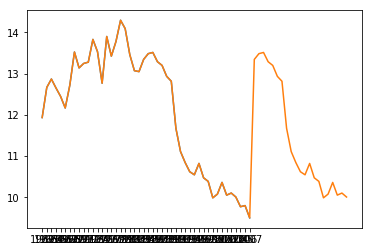

In [201]:
make_window_refitting_model(country = 'Germany', df_train = df_co2_train, df_val = df_co2_val, p = 0, d = 1, q = 1)

In [138]:
# array = np.array(df_co2_train.loc['Germany'])
# model = ARIMA(array, order=(0,1,1))
# fit = model.fit()
# preds = fit.predict(start = 2002, end = 2007)
# print(fit.summary())

In [81]:
preds

array([-0.04576669, -0.04707414, -0.04707414, ..., -0.04707414,
       -0.04707414, -0.04707414])